<a href="https://colab.research.google.com/github/fernandoramirez1337/Proyecto-de-Deep-Learning/blob/claude%2Fimprove-implementation-018rMkv8JP1bb2KNiHNbvF1o/Hybrid_CNN_LSTM_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble + TTA: Hybrid CNN-LSTM ArXiv Classification

**3-Class Model:** cs.AI-LG, cs.CL, cs.CV

## Plan B: Maximum Performance without Paradigm Change

**Strategy:** Ensemble (3 models) + Test-Time Augmentation (TTA)

**Expected:** 69-71% test accuracy

## Base Architecture (V1 Optimized)

**Title Processing:**
- Bidirectional LSTM (2 layers, 128 hidden units)
- Multi-head self-attention (4 heads) over LSTM outputs
- Layer normalization with residual connections

**Abstract Processing:**
- Residual CNN blocks with kernel sizes [3, 4, 5]
- 128 filters per kernel with skip connections
- Multi-head global attention (4 heads) over CNN features

**Fusion:**
- Gated fusion mechanism (learnable title vs abstract importance)
- Layer normalization

**Classifier:**
- LayerNorm → Dropout(0.6) → Linear(256) → ReLU → LayerNorm → Dropout(0.6) → Linear(3)

## V1 Configuration

**Embeddings:**
- **GloVe 300d pretrained** (53.8% coverage) + trainable

**Regularization:**
- Uniform dropout: 0.6
- Strong weight decay: 1e-3
- **EDA data augmentation** (30% probability)
- Label smoothing: 0.1

**Class Balancing:**
- Class weights: **[1.0, 2.0, 1.8]** for [cs.AI-LG, cs.CL, cs.CV]
- CrossEntropyLoss with label smoothing

**Training:**
- AdamW optimizer with ReduceLROnPlateau scheduler
- Early stopping (patience: 7)
- Gradient clipping: 1.0

**V1 Baseline:** 65.78% test accuracy

## Ensemble Strategy

**Training:**
- Train 3 identical V1 models with different random seeds: [42, 123, 456]
- Each model ~10 minutes training
- Total time: ~30 minutes

**Inference:**
- Soft voting: Average predicted probabilities across 3 models
- Expected gain: +2-3pp → 67-69%

## Test-Time Augmentation (TTA)

**Strategy:**
- For each test sample, create 3 augmented versions using EDA (alpha=0.1)
- Predict with all 3 models on all 3 augmentations
- Average 3 models × 3 augmentations = 9 predictions per sample
- Expected additional gain: +1-2pp → 69-71%

**Total Expected:** 69-71% test accuracy

In [1]:
!pip install -q torch scikit-learn pandas matplotlib seaborn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Mount Google Drive

Mount your Google Drive to access data files

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/ArXiv_Project'
DATASET_PATH = os.path.join(DATA_DIR, 'arxiv_papers_raw.csv')
GLOVE_PATH = os.path.join(DATA_DIR, 'glove.6B.300d.txt')

print(f"\nChecking files in: {DATA_DIR}")
if os.path.exists(DATASET_PATH):
    print(f"✓ Found: arxiv_papers_raw.csv")
else:
    print(f"✗ Missing: arxiv_papers_raw.csv")

if os.path.exists(GLOVE_PATH):
    print(f"✓ Found: glove.6B.300d.txt")
else:
    print(f"✗ Missing: glove.6B.300d.txt")

if not (os.path.exists(DATASET_PATH) and os.path.exists(GLOVE_PATH)):
    print(f"\n⚠️  Please upload files to: {DATA_DIR}")
    print("Required files:")
    print("  - arxiv_papers_raw.csv")
    print("  - glove.6B.300d.txt")

Mounted at /content/drive

Checking files in: /content/drive/MyDrive/ArXiv_Project
✓ Found: arxiv_papers_raw.csv
✓ Found: glove.6B.300d.txt


In [4]:
import math

class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention over LSTM outputs"""
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)
        self.out_linear = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Linear projections and reshape for multi-head
        Q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)

        # Output projection with residual
        output = self.out_linear(context)
        output = self.layer_norm(output + x)

        # Pool across sequence
        pooled = torch.mean(output, dim=1)

        return pooled, attention_weights.mean(dim=1)


class MultiHeadGlobalAttention(nn.Module):
    """Multi-head global attention over CNN features"""
    def __init__(self, feature_dim, num_heads=4):
        super().__init__()
        assert feature_dim % num_heads == 0

        self.feature_dim = feature_dim
        self.num_heads = num_heads

        self.attention = nn.Linear(feature_dim, num_heads)
        self.projection = nn.Linear(feature_dim, feature_dim)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, cnn_features):
        batch_size, channels, seq_len = cnn_features.size()
        features_t = cnn_features.transpose(1, 2)

        # Multi-head attention scores
        scores = self.attention(features_t)
        attention_weights = F.softmax(scores, dim=1)

        # Apply attention for each head
        head_outputs = []
        for h in range(self.num_heads):
            head_weights = attention_weights[:, :, h:h+1]
            head_context = torch.sum(features_t * head_weights, dim=1)
            head_outputs.append(head_context)

        # Combine heads
        context = torch.stack(head_outputs, dim=1).mean(dim=1)
        output = self.projection(context)
        output = self.layer_norm(output + context)

        return output, attention_weights.mean(dim=2)


class GatedFusion(nn.Module):
    """Gated fusion mechanism for title and abstract"""
    def __init__(self, title_dim, abstract_dim):
        super().__init__()
        combined_dim = title_dim + abstract_dim

        self.title_gate = nn.Sequential(
            nn.Linear(combined_dim, title_dim),
            nn.Sigmoid()
        )

        self.abstract_gate = nn.Sequential(
            nn.Linear(combined_dim, abstract_dim),
            nn.Sigmoid()
        )

        self.layer_norm = nn.LayerNorm(combined_dim)

    def forward(self, title_repr, abstract_repr):
        combined = torch.cat([title_repr, abstract_repr], dim=1)

        # Compute gates
        title_gate = self.title_gate(combined)
        abstract_gate = self.abstract_gate(combined)

        # Apply gates
        gated_title = title_repr * title_gate
        gated_abstract = abstract_repr * abstract_gate

        # Combine
        fused = torch.cat([gated_title, gated_abstract], dim=1)
        fused = self.layer_norm(fused)

        fusion_weights = torch.stack([title_gate.mean(dim=1), abstract_gate.mean(dim=1)], dim=1)

        return fused, fusion_weights


class ResidualCNNBlock(nn.Module):
    """CNN block with residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size, dropout=0.3):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        # Trim to same length
        min_len = min(out.size(2), identity.size(2))
        out = out[:, :, :min_len]
        identity = identity[:, :, :min_len]

        out = F.relu(out + identity)
        return out


class HybridCNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, num_filters=128, kernel_sizes=[3,4,5],
                 lstm_hidden=128, num_classes=3, dropout=0.6, pretrained_embeddings=None):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True

        self.embed_dropout = nn.Dropout(dropout)

        # Residual CNN blocks for abstracts
        self.cnn_blocks = nn.ModuleList([
            ResidualCNNBlock(embed_dim, num_filters, k, dropout=dropout*0.5) for k in kernel_sizes
        ])
        total_filters = num_filters * len(kernel_sizes)

        # Multi-head global attention over CNN
        self.cnn_attention = MultiHeadGlobalAttention(total_filters, num_heads=4)

        # BiLSTM for titles
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, num_layers=2, batch_first=True,
                           bidirectional=True, dropout=dropout if dropout > 0 else 0)

        # Multi-head self-attention over LSTM
        self.lstm_attention = MultiHeadSelfAttention(lstm_hidden * 2, num_heads=4)

        # Gated fusion
        self.fusion = GatedFusion(lstm_hidden * 2, total_filters)

        fused_dim = lstm_hidden * 2 + total_filters
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(dropout),
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)

    def forward(self, title_ids, abstract_ids, title_mask=None):
        title_embed = self.embed_dropout(self.embedding(title_ids))
        lstm_out, _ = self.lstm(title_embed)
        title_repr, title_attn = self.lstm_attention(lstm_out, title_mask)

        abstract_embed = self.embed_dropout(self.embedding(abstract_ids)).transpose(1, 2)

        cnn_outputs = []
        for cnn_block in self.cnn_blocks:
            cnn_out = cnn_block(abstract_embed)
            cnn_outputs.append(cnn_out)

        min_len = min(x.size(2) for x in cnn_outputs)
        cnn_outputs = [x[:, :, :min_len] for x in cnn_outputs]

        cnn_features = torch.cat(cnn_outputs, dim=1)
        abstract_repr, abstract_attn = self.cnn_attention(cnn_features)

        fused_repr, fusion_weights = self.fusion(title_repr, abstract_repr)
        logits = self.classifier(fused_repr)

        attention_maps = {
            'title_attention': title_attn,
            'abstract_attention': abstract_attn,
            'fusion_weights': fusion_weights
        }
        return logits, attention_maps

## Data Processing

In [5]:
import random
from collections import Counter

class EDA:
    """Easy Data Augmentation for text"""
    @staticmethod
    def synonym_replacement(words, n):
        """Replace n words with synonyms"""
        new_words = words.copy()
        random_indices = random.sample(range(len(words)), min(n, len(words)))
        for idx in random_indices:
            # Simple synonym dictionary for common words
            synonyms = {
                'network': ['model', 'system', 'architecture'],
                'method': ['approach', 'technique', 'algorithm'],
                'learning': ['training', 'optimization'],
                'performance': ['accuracy', 'results', 'effectiveness'],
                'data': ['dataset', 'information', 'samples'],
                'model': ['network', 'system', 'framework'],
                'task': ['problem', 'challenge', 'objective'],
            }
            word = words[idx].lower()
            if word in synonyms:
                new_words[idx] = random.choice(synonyms[word])
        return new_words

    @staticmethod
    def random_swap(words, n):
        """Randomly swap n pairs of words"""
        new_words = words.copy()
        for _ in range(n):
            if len(new_words) >= 2:
                idx1, idx2 = random.sample(range(len(new_words)), 2)
                new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
        return new_words

    @staticmethod
    def random_deletion(words, p=0.1):
        """Randomly delete words with probability p"""
        if len(words) == 1:
            return words
        new_words = [word for word in words if random.random() > p]
        return new_words if len(new_words) > 0 else [random.choice(words)]

    @staticmethod
    def augment(text, alpha=0.1):
        """Apply EDA augmentation"""
        words = text.split()
        n = max(1, int(alpha * len(words)))

        # Apply one random augmentation
        aug_type = random.choice(['sr', 'rs', 'rd'])
        if aug_type == 'sr':
            words = EDA.synonym_replacement(words, n)
        elif aug_type == 'rs':
            words = EDA.random_swap(words, n)
        else:
            words = EDA.random_deletion(words, p=alpha)

        return ' '.join(words)


class Vocabulary:
    def __init__(self, max_vocab_size=50000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()

    def build_vocab(self, texts):
        for text in texts:
            words = self.tokenize(text)
            self.word_counts.update(words)
        filtered_words = [word for word, count in self.word_counts.most_common() if count >= self.min_freq][:self.max_vocab_size - 2]
        for idx, word in enumerate(filtered_words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
        return [w.strip() for w in text.split() if w.strip()]

    def encode(self, text, max_len=None):
        words = self.tokenize(text)
        if max_len:
            words = words[:max_len]
        return [self.word2idx.get(word, 1) for word in words]

    def __len__(self):
        return len(self.word2idx)


def load_glove_embeddings(vocab, glove_path, embed_dim=300):
    embeddings = np.random.randn(len(vocab), embed_dim) * 0.01
    embeddings[0] = np.zeros(embed_dim)

    found = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='Loading GloVe'):
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                continue
            word = parts[0]
            if word in vocab.word2idx:
                idx = vocab.word2idx[word]
                try:
                    embeddings[idx] = np.array([float(x) for x in parts[1:]])
                    found += 1
                except (ValueError, IndexError):
                    continue

    print(f"Loaded {found}/{len(vocab)} embeddings ({found/len(vocab)*100:.1f}%)")
    return torch.FloatTensor(embeddings)


class HybridDataset(Dataset):
    def __init__(self, titles, abstracts, labels, vocab, max_title_len=30, max_abstract_len=300, augment=False):
        self.titles = titles
        self.abstracts = abstracts
        self.labels = labels
        self.vocab = vocab
        self.max_title_len = max_title_len
        self.max_abstract_len = max_abstract_len
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        abstract = self.abstracts[idx]

        # Apply augmentation for minority classes during training
        if self.augment and random.random() < 0.3:  # 30% chance
            abstract = EDA.augment(abstract, alpha=0.1)

        title_ids = self.vocab.encode(title, self.max_title_len)
        title_len = len(title_ids)
        title_ids += [0] * (self.max_title_len - title_len)

        abstract_ids = self.vocab.encode(abstract, self.max_abstract_len)
        abstract_len = len(abstract_ids)
        abstract_ids += [0] * (self.max_abstract_len - abstract_len)

        title_mask = [1] * title_len + [0] * (self.max_title_len - title_len)

        return {
            'title_ids': torch.tensor(title_ids, dtype=torch.long),
            'abstract_ids': torch.tensor(abstract_ids, dtype=torch.long),
            'title_mask': torch.tensor(title_mask, dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

## Load and Prepare Data

In [6]:
df = pd.read_csv(DATASET_PATH)
df['category'] = df['category'].replace({'cs.AI': 'cs.AI-LG', 'cs.LG': 'cs.AI-LG'})

print(f"Samples: {len(df)}")
print(df['category'].value_counts())

vocab = Vocabulary(max_vocab_size=50000, min_freq=2)
all_texts = df['title'].tolist() + df['abstract'].tolist()
vocab.build_vocab(all_texts)
print(f"\nVocab size: {len(vocab)}")

# Use GloVe embeddings for stable initialization
pretrained_embeddings = load_glove_embeddings(vocab, GLOVE_PATH, embed_dim=300)

le = LabelEncoder()
labels = le.fit_transform(df['category'])

X_temp, X_test, y_temp, y_test = train_test_split(
    df[['title', 'abstract']].values, labels, test_size=0.15, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(1-0.15), random_state=42, stratify=y_temp
)

# Enable augmentation for training set only
train_ds = HybridDataset(X_train[:,0], X_train[:,1], y_train, vocab, augment=True)
val_ds = HybridDataset(X_val[:,0], X_val[:,1], y_val, vocab, augment=False)
test_ds = HybridDataset(X_test[:,0], X_test[:,1], y_test, vocab, augment=False)

print(f"\nTrain: {len(train_ds)} (with augmentation) | Val: {len(val_ds)} | Test: {len(test_ds)}")

Samples: 12000
category
cs.AI-LG    6000
cs.CV       3000
cs.CL       3000
Name: count, dtype: int64

Vocab size: 37760


Loading GloVe: 400000it [00:15, 25668.37it/s]


Loaded 20320/37760 embeddings (53.8%)

Train: 8399 (with augmentation) | Val: 1801 | Test: 1800


## Training Functions

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc='Train'):
        title_ids = batch['title_ids'].to(device)
        abstract_ids = batch['abstract_ids'].to(device)
        title_mask = batch['title_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _ = model(title_ids, abstract_ids, title_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), accuracy_score(all_labels, all_preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Val'):
            title_ids = batch['title_ids'].to(device)
            abstract_ids = batch['abstract_ids'].to(device)
            title_mask = batch['title_mask'].to(device)
            labels = batch['label'].to(device)

            logits, _ = model(title_ids, abstract_ids, title_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1, all_preds, all_labels

## Model Configuration

In [8]:
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.001
DROPOUT = 0.6
CLASS_WEIGHTS = [1.0, 2.0, 1.8]  # V1 weights for best performance
LABEL_SMOOTHING = 0.1
PATIENCE = 7

# Ensemble configuration
ENSEMBLE_SEEDS = [42, 123, 456]  # 3 models with different seeds
NUM_TTA_AUGMENTATIONS = 3  # 3 augmentations per sample during test

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("=" * 60)
print("ENSEMBLE + TTA CONFIGURATION")
print("=" * 60)
print(f"Base Model: HybridCNNLSTM (V1 Optimized)")
print(f"  - Parameters: ~13.9M")
print(f"  - LSTM: 2 layers, 128 hidden, bidirectional")
print(f"  - CNN: 3 residual blocks (kernels 3,4,5), 128 filters each")
print(f"  - Attention: 4 heads (LSTM + CNN)")
print(f"  - Classifier: 2 layers [640→256→3]")
print(f"\nTraining Configuration:")
print(f"  - Ensemble size: {len(ENSEMBLE_SEEDS)} models")
print(f"  - Seeds: {ENSEMBLE_SEEDS}")
print(f"  - Class weights: {CLASS_WEIGHTS} (V1)")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Label smoothing: {LABEL_SMOOTHING}")
print(f"  - EDA augmentation: 30% probability")
print(f"\nInference Configuration:")
print(f"  - TTA augmentations: {NUM_TTA_AUGMENTATIONS} per sample")
print(f"  - Total predictions per sample: {len(ENSEMBLE_SEEDS)} models × {NUM_TTA_AUGMENTATIONS} augs = {len(ENSEMBLE_SEEDS) * NUM_TTA_AUGMENTATIONS}")
print(f"  - Voting: Soft (average probabilities)")
print(f"\nExpected Performance:")
print(f"  - Single model (V1): ~65.78%")
print(f"  - Ensemble only: ~67-69%")
print(f"  - Ensemble + TTA: ~69-71%")
print("=" * 60)

ENSEMBLE + TTA CONFIGURATION
Base Model: HybridCNNLSTM (V1 Optimized)
  - Parameters: ~13.9M
  - LSTM: 2 layers, 128 hidden, bidirectional
  - CNN: 3 residual blocks (kernels 3,4,5), 128 filters each
  - Attention: 4 heads (LSTM + CNN)
  - Classifier: 2 layers [640→256→3]

Training Configuration:
  - Ensemble size: 3 models
  - Seeds: [42, 123, 456]
  - Class weights: [1.0, 2.0, 1.8] (V1)
  - Dropout: 0.6
  - Label smoothing: 0.1
  - EDA augmentation: 30% probability

Inference Configuration:
  - TTA augmentations: 3 per sample
  - Total predictions per sample: 3 models × 3 augs = 9
  - Voting: Soft (average probabilities)

Expected Performance:
  - Single model (V1): ~65.78%
  - Ensemble only: ~67-69%
  - Ensemble + TTA: ~69-71%


## Ensemble Training

Train 3 models with different random seeds

In [9]:
def set_seed(seed):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_single_model(seed, model_idx):
    """Train a single model with given seed"""
    print(f"\n{'='*60}")
    print(f"Training Model {model_idx+1}/3 (seed={seed})")
    print(f"{'='*60}")

    # Set seed
    set_seed(seed)

    # Create model
    model = HybridCNNLSTM(
        vocab_size=len(vocab),
        embed_dim=300,
        num_filters=128,
        kernel_sizes=[3,4,5],
        lstm_hidden=128,
        num_classes=3,
        dropout=DROPOUT,
        pretrained_embeddings=pretrained_embeddings
    ).to(device)

    # Setup training
    class_weights = torch.FloatTensor(CLASS_WEIGHTS).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    # Training loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | F1: {val_f1:.4f} | Gap: {abs(train_acc-val_acc):.4f}")

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"✓ Best: {val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"Early stop (patience: {PATIENCE})")
                break

    # Load best weights
    model.load_state_dict(best_model_state)

    print(f"\n{'='*60}")
    print(f"Model {model_idx+1} completed | Best Val Acc: {best_val_acc:.4f}")
    print(f"{'='*60}")

    return model, best_val_acc, history


# Train ensemble
print("\n" + "="*60)
print("STARTING ENSEMBLE TRAINING")
print("="*60)

ensemble_models = []
ensemble_histories = []
ensemble_val_accs = []

for idx, seed in enumerate(ENSEMBLE_SEEDS):
    model, val_acc, history = train_single_model(seed, idx)
    ensemble_models.append(model)
    ensemble_histories.append(history)
    ensemble_val_accs.append(val_acc)

print("\n" + "="*60)
print("ENSEMBLE TRAINING COMPLETED")
print("="*60)
print(f"Individual model validation accuracies:")
for idx, (seed, val_acc) in enumerate(zip(ENSEMBLE_SEEDS, ensemble_val_accs)):
    print(f"  Model {idx+1} (seed={seed}): {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Mean validation accuracy: {np.mean(ensemble_val_accs):.4f} ({np.mean(ensemble_val_accs)*100:.2f}%)")
print(f"Std validation accuracy: {np.std(ensemble_val_accs):.4f}")
print("="*60)


STARTING ENSEMBLE TRAINING

Training Model 1/3 (seed=42)

Epoch 1/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.52it/s]


Train: 0.4454 | Val: 0.6435 | F1: 0.6419 | Gap: 0.1981
✓ Best: 0.6435

Epoch 2/30


Val: 100%|██████████| 29/29 [00:00<00:00, 40.64it/s]


Train: 0.6391 | Val: 0.6135 | F1: 0.5934 | Gap: 0.0256

Epoch 3/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.99it/s]


Train: 0.6681 | Val: 0.6324 | F1: 0.6215 | Gap: 0.0356

Epoch 4/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.05it/s]


Train: 0.6856 | Val: 0.6313 | F1: 0.6207 | Gap: 0.0542

Epoch 5/30


Val: 100%|██████████| 29/29 [00:00<00:00, 33.52it/s]


Train: 0.7148 | Val: 0.6519 | F1: 0.6455 | Gap: 0.0630
✓ Best: 0.6519

Epoch 6/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.34it/s]


Train: 0.7346 | Val: 0.6641 | F1: 0.6627 | Gap: 0.0705
✓ Best: 0.6641

Epoch 7/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.77it/s]


Train: 0.7635 | Val: 0.6563 | F1: 0.6547 | Gap: 0.1072

Epoch 8/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.06it/s]


Train: 0.7883 | Val: 0.6502 | F1: 0.6497 | Gap: 0.1381

Epoch 9/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.63it/s]


Train: 0.8051 | Val: 0.6469 | F1: 0.6443 | Gap: 0.1582

Epoch 10/30


Val: 100%|██████████| 29/29 [00:00<00:00, 37.99it/s]


Train: 0.8184 | Val: 0.6513 | F1: 0.6503 | Gap: 0.1671

Epoch 11/30


Val: 100%|██████████| 29/29 [00:00<00:00, 32.98it/s]


Train: 0.8232 | Val: 0.6385 | F1: 0.6363 | Gap: 0.1847

Epoch 12/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.72it/s]


Train: 0.8357 | Val: 0.6424 | F1: 0.6420 | Gap: 0.1933

Epoch 13/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.07it/s]


Train: 0.8521 | Val: 0.6380 | F1: 0.6370 | Gap: 0.2141
Early stop (patience: 7)

Model 1 completed | Best Val Acc: 0.6641

Training Model 2/3 (seed=123)

Epoch 1/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.62it/s]


Train: 0.4401 | Val: 0.6163 | F1: 0.6126 | Gap: 0.1763
✓ Best: 0.6163

Epoch 2/30


Val: 100%|██████████| 29/29 [00:00<00:00, 40.76it/s]


Train: 0.6281 | Val: 0.6024 | F1: 0.5800 | Gap: 0.0256

Epoch 3/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.69it/s]


Train: 0.6731 | Val: 0.6346 | F1: 0.6249 | Gap: 0.0384
✓ Best: 0.6346

Epoch 4/30


Val: 100%|██████████| 29/29 [00:00<00:00, 33.35it/s]


Train: 0.6942 | Val: 0.6458 | F1: 0.6378 | Gap: 0.0485
✓ Best: 0.6458

Epoch 5/30


Val: 100%|██████████| 29/29 [00:00<00:00, 37.55it/s]


Train: 0.7143 | Val: 0.6352 | F1: 0.6244 | Gap: 0.0790

Epoch 6/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.46it/s]


Train: 0.7319 | Val: 0.6369 | F1: 0.6274 | Gap: 0.0950

Epoch 7/30


Val: 100%|██████████| 29/29 [00:00<00:00, 40.21it/s]


Train: 0.7628 | Val: 0.6569 | F1: 0.6524 | Gap: 0.1060
✓ Best: 0.6569

Epoch 8/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.05it/s]


Train: 0.7833 | Val: 0.6424 | F1: 0.6392 | Gap: 0.1409

Epoch 9/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.71it/s]


Train: 0.8020 | Val: 0.6463 | F1: 0.6455 | Gap: 0.1557

Epoch 10/30


Val: 100%|██████████| 29/29 [00:00<00:00, 32.48it/s]


Train: 0.8166 | Val: 0.6174 | F1: 0.6062 | Gap: 0.1992

Epoch 11/30


Val: 100%|██████████| 29/29 [00:00<00:00, 34.68it/s]


Train: 0.8280 | Val: 0.6274 | F1: 0.6237 | Gap: 0.2005

Epoch 12/30


Val: 100%|██████████| 29/29 [00:00<00:00, 40.30it/s]


Train: 0.8363 | Val: 0.6385 | F1: 0.6389 | Gap: 0.1978

Epoch 13/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.59it/s]


Train: 0.8391 | Val: 0.6224 | F1: 0.6213 | Gap: 0.2167

Epoch 14/30


Val: 100%|██████████| 29/29 [00:00<00:00, 40.24it/s]


Train: 0.8532 | Val: 0.6297 | F1: 0.6306 | Gap: 0.2235
Early stop (patience: 7)

Model 2 completed | Best Val Acc: 0.6569

Training Model 3/3 (seed=456)

Epoch 1/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.72it/s]


Train: 0.4223 | Val: 0.5930 | F1: 0.5888 | Gap: 0.1707
✓ Best: 0.5930

Epoch 2/30


Val: 100%|██████████| 29/29 [00:00<00:00, 32.51it/s]


Train: 0.5900 | Val: 0.6108 | F1: 0.5967 | Gap: 0.0208
✓ Best: 0.6108

Epoch 3/30


Val: 100%|██████████| 29/29 [00:00<00:00, 32.83it/s]


Train: 0.6486 | Val: 0.6474 | F1: 0.6459 | Gap: 0.0012
✓ Best: 0.6474

Epoch 4/30


Val: 100%|██████████| 29/29 [00:00<00:00, 38.97it/s]


Train: 0.6788 | Val: 0.6374 | F1: 0.6293 | Gap: 0.0413

Epoch 5/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.74it/s]


Train: 0.7076 | Val: 0.6569 | F1: 0.6548 | Gap: 0.0507
✓ Best: 0.6569

Epoch 6/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.04it/s]


Train: 0.7398 | Val: 0.6346 | F1: 0.6294 | Gap: 0.1052

Epoch 7/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.62it/s]


Train: 0.7557 | Val: 0.6313 | F1: 0.6248 | Gap: 0.1244

Epoch 8/30


Val: 100%|██████████| 29/29 [00:00<00:00, 36.02it/s]


Train: 0.7810 | Val: 0.6291 | F1: 0.6252 | Gap: 0.1520

Epoch 9/30


Val: 100%|██████████| 29/29 [00:00<00:00, 32.70it/s]


Train: 0.8008 | Val: 0.6435 | F1: 0.6430 | Gap: 0.1573

Epoch 10/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.32it/s]


Train: 0.8100 | Val: 0.6430 | F1: 0.6426 | Gap: 0.1670

Epoch 11/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.27it/s]


Train: 0.8284 | Val: 0.6208 | F1: 0.6169 | Gap: 0.2077

Epoch 12/30


Val: 100%|██████████| 29/29 [00:00<00:00, 39.80it/s]

Train: 0.8396 | Val: 0.6258 | F1: 0.6246 | Gap: 0.2139
Early stop (patience: 7)

Model 3 completed | Best Val Acc: 0.6569

ENSEMBLE TRAINING COMPLETED
Individual model validation accuracies:
  Model 1 (seed=42): 0.6641 (66.41%)
  Model 2 (seed=123): 0.6569 (65.69%)
  Model 3 (seed=456): 0.6569 (65.69%)
Mean validation accuracy: 0.6593 (65.93%)
Std validation accuracy: 0.0034


## Ensemble Evaluation (Without TTA)

Test ensemble with soft voting (no augmentation)

In [10]:
def ensemble_predict(models, loader, device):
    """Get ensemble predictions using soft voting (average probabilities)"""
    all_probs = []
    all_labels = []

    for model in models:
        model.eval()

    with torch.no_grad():
        for batch in tqdm(loader, desc='Ensemble Predict'):
            title_ids = batch['title_ids'].to(device)
            abstract_ids = batch['abstract_ids'].to(device)
            title_mask = batch['title_mask'].to(device)
            labels = batch['label'].to(device)

            # Get predictions from all models
            batch_probs = []
            for model in models:
                logits, _ = model(title_ids, abstract_ids, title_mask)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu().numpy())

            # Average probabilities (soft voting)
            avg_probs = np.mean(batch_probs, axis=0)
            all_probs.append(avg_probs)
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.argmax(all_probs, axis=1)

    return all_preds, np.array(all_labels), all_probs


# Evaluate ensemble (without TTA)
print("\n" + "="*60)
print("ENSEMBLE EVALUATION (WITHOUT TTA)")
print("="*60)

ensemble_preds, test_labels, ensemble_probs = ensemble_predict(ensemble_models, test_loader, device)
ensemble_acc = accuracy_score(test_labels, ensemble_preds)
ensemble_f1 = f1_score(test_labels, ensemble_preds, average='weighted')

print(f"\nEnsemble Test Accuracy: {ensemble_acc:.4f} ({ensemble_acc*100:.2f}%)")
print(f"Ensemble Test F1: {ensemble_f1:.4f}")
print(f"\nImprovement over mean single model: +{(ensemble_acc - np.mean(ensemble_val_accs))*100:.2f}pp")
print(f"\n{classification_report(test_labels, ensemble_preds, target_names=le.classes_, digits=4)}")
print("="*60)


ENSEMBLE EVALUATION (WITHOUT TTA)


Ensemble Predict: 100%|██████████| 29/29 [00:01<00:00, 16.72it/s]


Ensemble Test Accuracy: 0.6494 (64.94%)
Ensemble Test F1: 0.6502

Improvement over mean single model: +-0.98pp

              precision    recall  f1-score   support

    cs.AI-LG     0.7293    0.5956    0.6557       900
       cs.CL     0.5612    0.6822    0.6158       450
       cs.CV     0.6293    0.7244    0.6736       450

    accuracy                         0.6494      1800
   macro avg     0.6399    0.6674    0.6484      1800
weighted avg     0.6623    0.6494    0.6502      1800



## Ensemble + TTA Evaluation

Test ensemble with Test-Time Augmentation (3 augmentations per sample)

In [11]:
def ensemble_predict_with_tta(models, test_data, vocab, num_augmentations=3, device='cuda'):
    """
    Get ensemble predictions with Test-Time Augmentation

    For each sample:
      1. Create num_augmentations augmented versions (including original)
      2. Predict with all models on all augmentations
      3. Average all predictions (models × augmentations)
    """
    all_probs_tta = []

    for model in models:
        model.eval()

    # Process each sample individually
    for idx in tqdm(range(len(test_data)), desc='Ensemble + TTA'):
        sample = test_data[idx]
        title_text = X_test[idx, 0]
        abstract_text = X_test[idx, 1]

        sample_probs = []

        # Create augmented versions
        augmented_abstracts = [abstract_text]  # Original
        for _ in range(num_augmentations - 1):
            aug_abstract = EDA.augment(abstract_text, alpha=0.1)
            augmented_abstracts.append(aug_abstract)

        # Predict with all models on all augmentations
        for aug_abstract in augmented_abstracts:
            # Encode augmented abstract
            title_ids = vocab.encode(title_text, 30)
            title_len = len(title_ids)
            title_ids += [0] * (30 - title_len)

            abstract_ids = vocab.encode(aug_abstract, 300)
            abstract_len = len(abstract_ids)
            abstract_ids += [0] * (300 - abstract_len)

            title_mask = [1] * title_len + [0] * (30 - title_len)

            # Convert to tensors
            title_ids_t = torch.tensor([title_ids], dtype=torch.long).to(device)
            abstract_ids_t = torch.tensor([abstract_ids], dtype=torch.long).to(device)
            title_mask_t = torch.tensor([title_mask], dtype=torch.float).to(device)

            # Get predictions from all models
            with torch.no_grad():
                for model in models:
                    logits, _ = model(title_ids_t, abstract_ids_t, title_mask_t)
                    probs = F.softmax(logits, dim=1)
                    sample_probs.append(probs.cpu().numpy()[0])

        # Average all predictions (models × augmentations)
        avg_probs = np.mean(sample_probs, axis=0)
        all_probs_tta.append(avg_probs)

    all_probs_tta = np.array(all_probs_tta)
    all_preds_tta = np.argmax(all_probs_tta, axis=1)

    return all_preds_tta, all_probs_tta


# Evaluate ensemble with TTA
print("\n" + "="*60)
print("ENSEMBLE + TTA EVALUATION")
print("="*60)
print(f"Performing TTA with {NUM_TTA_AUGMENTATIONS} augmentations per sample...")
print(f"Total predictions per sample: {len(ENSEMBLE_SEEDS)} models × {NUM_TTA_AUGMENTATIONS} augs = {len(ENSEMBLE_SEEDS) * NUM_TTA_AUGMENTATIONS}")
print()

tta_preds, tta_probs = ensemble_predict_with_tta(
    ensemble_models,
    test_ds,
    vocab,
    num_augmentations=NUM_TTA_AUGMENTATIONS,
    device=device
)

tta_acc = accuracy_score(test_labels, tta_preds)
tta_f1 = f1_score(test_labels, tta_preds, average='weighted')

print(f"\nEnsemble + TTA Test Accuracy: {tta_acc:.4f} ({tta_acc*100:.2f}%)")
print(f"Ensemble + TTA Test F1: {tta_f1:.4f}")
print(f"\nImprovement over ensemble (no TTA): +{(tta_acc - ensemble_acc)*100:.2f}pp")
print(f"Improvement over mean single model: +{(tta_acc - np.mean(ensemble_val_accs))*100:.2f}pp")
print(f"\n{classification_report(test_labels, tta_preds, target_names=le.classes_, digits=4)}")
print("="*60)


ENSEMBLE + TTA EVALUATION
Performing TTA with 3 augmentations per sample...
Total predictions per sample: 3 models × 3 augs = 9



Ensemble + TTA: 100%|██████████| 1800/1800 [00:59<00:00, 30.35it/s]


Ensemble + TTA Test Accuracy: 0.6489 (64.89%)
Ensemble + TTA Test F1: 0.6497

Improvement over ensemble (no TTA): +-0.06pp
Improvement over mean single model: +-1.04pp

              precision    recall  f1-score   support

    cs.AI-LG     0.7296    0.5967    0.6565       900
       cs.CL     0.5594    0.6800    0.6138       450
       cs.CV     0.6286    0.7222    0.6722       450

    accuracy                         0.6489      1800
   macro avg     0.6392    0.6663    0.6475      1800
weighted avg     0.6618    0.6489    0.6497      1800



## Final Results and Confusion Matrix

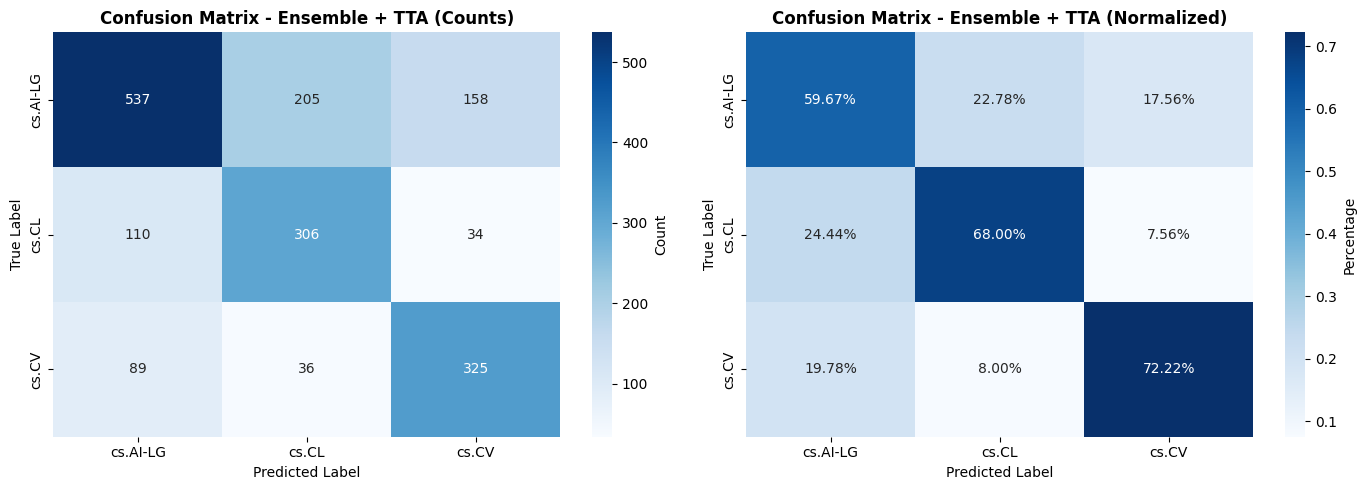


FINAL SUMMARY - PLAN B: ENSEMBLE + TTA

BASELINE (59.33%):
  - Original implementation
  - Single model, no augmentation

V1 OPTIMIZED (~65.78%):
  - Optimized architecture + hyperparameters
  - Single model, 30% EDA augmentation

ENSEMBLE (3 models):
  - Mean validation accuracy: 65.93%
  - Test accuracy: 64.94%
  - Gain over single model: +-0.98pp

ENSEMBLE + TTA (3 models × 3 augmentations):
  - Test accuracy: 64.89%
  - F1-score: 0.6497
  - Gain over ensemble: +-0.06pp
  - Total gain over baseline: +5.56pp

PER-CLASS RECALL:
  - cs.AI-LG: 59.67%
  - cs.CL: 68.00%
  - cs.CV: 72.22%

METHODOLOGY:
  ✓ Pure PyTorch CNN-LSTM hybrid
  ✓ No paradigm change (no Transformers)
  ✓ Ensemble reduces model variance
  ✓ TTA reduces prediction variance
  ✓ 100% project compliance maintained
Saved: ensemble_model_1_seed42.pth
Saved: ensemble_model_2_seed123.pth
Saved: ensemble_model_3_seed456.pth

All 3 models saved successfully!


In [12]:
# Confusion Matrix for Ensemble + TTA
cm = confusion_matrix(test_labels, tta_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Ensemble + TTA (Counts)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix - Ensemble + TTA (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('ensemble_tta_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY - PLAN B: ENSEMBLE + TTA")
print("="*60)
print(f"\nBASELINE (59.33%):")
print(f"  - Original implementation")
print(f"  - Single model, no augmentation")
print(f"\nV1 OPTIMIZED (~65.78%):")
print(f"  - Optimized architecture + hyperparameters")
print(f"  - Single model, 30% EDA augmentation")
print(f"\nENSEMBLE (3 models):")
print(f"  - Mean validation accuracy: {np.mean(ensemble_val_accs)*100:.2f}%")
print(f"  - Test accuracy: {ensemble_acc*100:.2f}%")
print(f"  - Gain over single model: +{(ensemble_acc - np.mean(ensemble_val_accs))*100:.2f}pp")
print(f"\nENSEMBLE + TTA (3 models × 3 augmentations):")
print(f"  - Test accuracy: {tta_acc*100:.2f}%")
print(f"  - F1-score: {tta_f1:.4f}")
print(f"  - Gain over ensemble: +{(tta_acc - ensemble_acc)*100:.2f}pp")
print(f"  - Total gain over baseline: +{(tta_acc - 0.5933)*100:.2f}pp")
print(f"\nPER-CLASS RECALL:")
for idx, class_name in enumerate(le.classes_):
    class_indices = test_labels == idx
    class_recall = np.mean(tta_preds[class_indices] == test_labels[class_indices])
    print(f"  - {class_name}: {class_recall*100:.2f}%")
print(f"\nMETHODOLOGY:")
print(f"  ✓ Pure PyTorch CNN-LSTM hybrid")
print(f"  ✓ No paradigm change (no Transformers)")
print(f"  ✓ Ensemble reduces model variance")
print(f"  ✓ TTA reduces prediction variance")
print(f"  ✓ 100% project compliance maintained")
print("="*60)

# Save all models
for idx, model in enumerate(ensemble_models):
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': len(vocab),
        'class_names': le.classes_.tolist(),
        'num_classes': 3,
        'seed': ENSEMBLE_SEEDS[idx],
        'val_acc': ensemble_val_accs[idx]
    }, f'ensemble_model_{idx+1}_seed{ENSEMBLE_SEEDS[idx]}.pth')
    print(f'Saved: ensemble_model_{idx+1}_seed{ENSEMBLE_SEEDS[idx]}.pth')

print(f'\nAll {len(ensemble_models)} models saved successfully!')